# Titanic Decision Tree

In [1]:
import pandas as pd

titanic = pd.read_csv('https://web.stanford.edu/class/archive' \
                      '/cs/cs109/cs109.1166/stuff/titanic.csv')
titanic.drop('Name', axis=1, inplace=True)
titanic['Sex'] = pd.get_dummies(titanic['Sex'])
data = titanic.values
rows, columns = data.shape

lowest_gini = ['Feature', 'Value', 0.50]
for column in range(1, columns):
    data_ = data[data[:, column].argsort()]
    
    for row in range(1, rows):
        L, R = data_[:row, 0], data_[row:, 0]

        gini_L = 1 - (sum(L==0)/len(L))**2 - (sum(L==1)/len(L))**2
        gini_R = 1 - (sum(R==0)/len(R))**2 - (sum(R==1)/len(R))**2

        gini = (len(L)*gini_L + len(R)*gini_R) / (len(L)+len(R))
        
        if gini < lowest_gini[2]: 
            lowest_gini = [titanic.columns[column], data_[row, column], gini]

print('Best split-feature     :', {lowest_gini[0]})
print('Value to split on      :', {lowest_gini[1]})
print('Weighted gini impurity :', {round(lowest_gini[2], 5)})

('Best split-feature     :', set(['Pclass']))
('Value to split on      :', set([1.0]))
('Weighted gini impurity :', set([0.0]))


## Visualization with export_graphviz

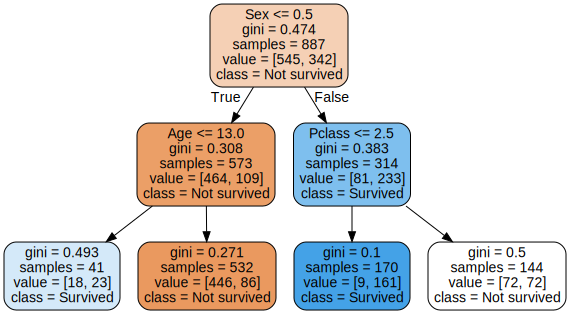

In [2]:
from sklearn import tree
from graphviz import Source

X = titanic.drop('Survived', axis=1).values
y = titanic['Survived'].values

model = tree.DecisionTreeClassifier(max_depth=2)
model.fit(X, y)

graph = Source(tree.export_graphviz(model, out_file=None,
                                    feature_names=titanic.columns[1:],
                                    class_names=['Not survived', 'Survived'],
                                    filled=True, rounded=True))
graph

It was more likely to not survive to the Titanic sinking, sniff sniff. As we can see from the first figure, the Decision tree starts to split over the sex, 0 = male, 1 = female, then it asks if the person is a kind (Age <= 13) in case that the model went for the true label (male), so if we follow this branch, it starts by asking "Is the person male?" If so, then asks "Is the person a kid (Age under 13)? and then it reaches a leaf node, where if the person is a male and a kid, he survived, if its not a kid, then he does'nt survived.

Similarly, if we go for the false branch, which is telling us that the person is a female, then, it asks what was the class the female was (1st, 2nd or 3rd class), If the person was from first class, then she survives, in the other case she did not survived.

From this graph info we can say the following

The Survived class is composed by kids and women from 1st class, each with 41 and 170 samples respectively, in the other case, the Not Survived class is telling us that almost every single man did not survive (532) and that the women from classes 2nd and 3rd also did not survived. Very sad times here.

In [4]:
 titanic.groupby('Sex').count() ## 0 = male, 1 = female

,Survived,Pclass,Age,Siblings/Spouses Aboard,Parents/Children Aboard,Fare
Sex,,,,,,
0,573,573,573,573,573,573
1,314,314,314,314,314,314


## Scikit-Learn Train-Test

In [5]:
features = ['Pclass', 'Sex', 'Age', 'Siblings/Spouses Aboard', 'Parents/Children Aboard', 'Fare']
X = titanic[features]
y = titanic.Survived

In [6]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 1)

In [15]:
#Create Decision tree classifier object, we can change the min_samples_leaf for better accuracy
dt = DecisionTreeClassifier(criterion='entropy', min_samples_leaf=4)
#train decision tree classifier
dt = dt.fit(X_train, y_train)
#Predict the response for test dataset
y_pred = dt.predict(X_test)
#Model accuracy, how often is the classifier correct
print("Accuracy:", metrics.accuracy_score(y_test, y_pred))

('Accuracy:', 0.7940074906367042)


The entropy criterion gives a better classificacion accuracy for the test and prediction

## Confusion matrix

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


np.set_printoptions(precision=2)

Confusion matrix, without normalization
[[137  25]
 [ 30  75]]


<Figure size 432x288 with 0 Axes>

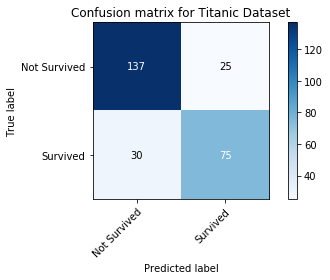

In [17]:
class_names=['Not Survived','Survived']
# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(y_test, y_pred, classes=class_names,
                      title='Confusion matrix for Titanic Dataset')

## Prediction probabilities for Titanic dataset and ROC curve

In [18]:
r_probs = [0 for _ in range(len(y_test))]
dt_probs = dt.predict_proba(X_test)

Probabilities for the positive outcome is kept.

In [19]:
dt_probs = dt_probs[:, 1]

In [20]:
from sklearn.metrics import roc_curve, roc_auc_score
r_auc = roc_auc_score(y_test, r_probs)
dt_auc = roc_auc_score(y_test, dt_probs)

In [21]:
print('Random (chance) Prediction: AUROC = %.3f' % (r_auc))
print('Decision Tree: AUROC = %.3f' % (dt_auc))
#print('Naive Bayes: AUROC = %.3f' % (nb_auc))

Random (chance) Prediction: AUROC = 0.500
Decision Tree: AUROC = 0.841


In [22]:
r_fpr, r_tpr, _ = roc_curve(y_test, r_probs)
dt_fpr, dt_tpr, _ = roc_curve(y_test, dt_probs)

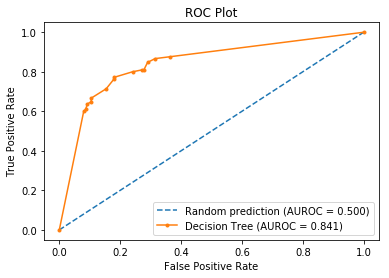

In [23]:
plt.plot(r_fpr, r_tpr, linestyle='--', label='Random prediction (AUROC = %0.3f)' % r_auc)
plt.plot(dt_fpr, dt_tpr, marker='.', label='Decision Tree (AUROC = %0.3f)' % dt_auc)
#plt.plot(nb_fpr, nb_tpr, marker='.', label='Naive Bayes (AUROC = %0.3f)' % nb_auc)

# Title
plt.title('ROC Plot')
# Axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# Show legend
plt.legend() # 
# Show plot
plt.show()
